In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [30]:
import pandas as pd

cafe_df = pd.read_csv('auscafe.csv', parse_dates=['date'])
cafe = pd.Series(data=cafe_df['Y'].values, index=cafe_df['date'])

print(cafe.head())

date
1982-04-01    0.3424
1982-05-01    0.3421
1982-06-01    0.3287
1982-07-01    0.3385
1982-08-01    0.3315
dtype: float64


In [31]:
train_size = int(len(cafe) * 0.8)
train, test = cafe[:train_size], cafe[train_size:]


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

train = train.asfreq("MS")
ses_model = SimpleExpSmoothing(train, initialization_method="estimated").fit(smoothing_level=0.3)
ses_forecast = ses_model.forecast(len(test))

rmse = np.sqrt(mean_squared_error(test, ses_forecast))
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test, ses_forecast)
print(f'MAPE: {mape}')

RMSE: 0.6630312957730997
MAPE: 0.16557294556127175


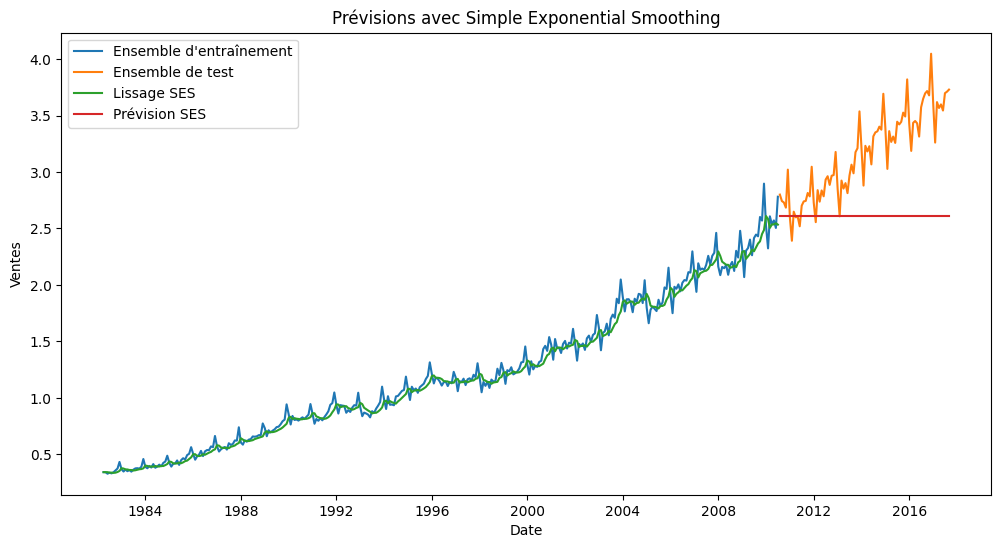

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(ses_model.fittedvalues, label='Lissage SES')
plt.plot(ses_forecast, label='Prévision SES')
plt.title('Prévisions avec Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


In [68]:
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

train = train.asfreq('MS')
test = test.asfreq('MS')

def evaluate_holt(exponential, damped_trend):
    model = Holt(train, exponential=exponential, damped_trend=damped_trend, initialization_method="estimated").fit(smoothing_level=0.94)
    forecast = model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    return model, forecast, rmse, mape

combinations = [(False, False), (True, False), (False, True), (True, True)]
results = {}

for exp, damp in combinations:
    model, forecast, rmse, mape = evaluate_holt(exp, damp)
    key = f'exponential={exp}, damped_trend={damp}'
    results[key] = {'model': model, 'forecast': forecast, 'rmse': rmse, 'mape': mape}

for key, value in results.items():
    print(f'{key}: RMSE={value["rmse"]}, MAPE={value["mape"]}')


exponential=False, damped_trend=False: RMSE=0.24020687476524014, MAPE=0.06113871720694794
exponential=True, damped_trend=False: RMSE=0.24978524085101803, MAPE=0.07098187488496399
exponential=False, damped_trend=True: RMSE=0.47107183414429976, MAPE=0.11174898708374775
exponential=True, damped_trend=True: RMSE=0.23185626766781417, MAPE=0.059782967124767626


In [69]:
# Trouver la meilleure combinaison de paramètres
best_combination = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_combination]['model']
best_forecast = results[best_combination]['forecast']
best_rmse = results[best_combination]['rmse']
best_mape = results[best_combination]['mape']

print(f'La meilleure combinaison est: {best_combination}')
print(f'RMSE: {best_rmse}')
print(f'MAPE: {best_mape}')


La meilleure combinaison est: exponential=True, damped_trend=True
RMSE: 0.23185626766781417
MAPE: 0.059782967124767626


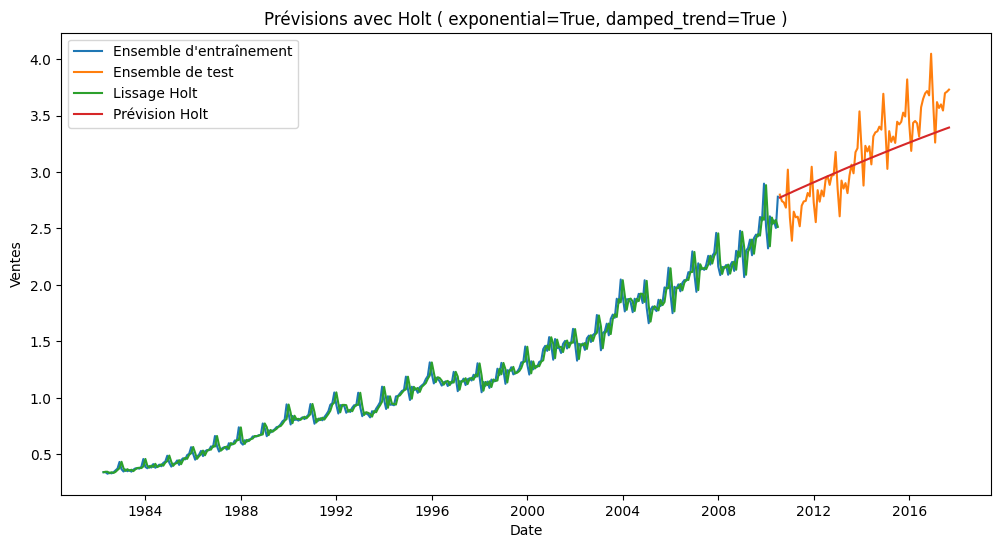

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(best_model.fittedvalues, label='Lissage Holt')
plt.plot(best_forecast, label='Prévision Holt')
plt.title(f'Prévisions avec Holt ( {best_combination} )')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


0

In [84]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import itertools

train = train.asfreq('MS')
test = test.asfreq('MS')

def evaluate_holt_winters(trend, seasonal, damped_trend, use_boxcox):
    try:
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, damped_trend=damped_trend, use_boxcox=use_boxcox).fit()
        forecast = model.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = mean_absolute_percentage_error(test, forecast)
        return model, forecast, rmse, mape
    except (ValueError, np.linalg.LinAlgError) as e:
        print(f"Combination {trend}-{seasonal}-{damped_trend}-{use_boxcox} failed: {e}")
        return None, None, np.inf, np.inf

param_grid = {
    'trend': ['add'],
    'seasonal': ['add'],
    'damped_trend': [True, False],
    'use_boxcox': [True, False]
}

results = {}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for params in combinations:
    model, forecast, rmse, mape = evaluate_holt_winters(params['trend'], params['seasonal'], params['damped_trend'], params['use_boxcox'])
    if model is not None:
        key = f"trend={params['trend']}, seasonal={params['seasonal']}, damped_trend={params['damped_trend']}, boxcox={params['use_boxcox']}"
        results[key] = {'model': model, 'forecast': forecast, 'rmse': rmse, 'mape': mape}

# Affichage des meilleurs scores RMSE et MAPE
best_rmse = min(results.items(), key=lambda x: x[1]['rmse'])
best_mape = min(results.items(), key=lambda x: x[1]['mape'])


best_model = results[best_combination]['model']
best_forecast = results[best_combination]['forecast']



print(f'Best RMSE: {best_rmse[0]} with RMSE={best_rmse[1]["rmse"]}, MAPE={best_rmse[1]["mape"]}')
print(f'Best MAPE: {best_mape[0]} with RMSE={best_mape[1]["rmse"]}, MAPE={best_mape[1]["mape"]}')

# Affichage de tous les résultats pour référence
for key, value in results.items():
    print(f'{key}: RMSE={value["rmse"]}, MAPE={value["mape"]}')


Best RMSE: trend=add, seasonal=add, damped_trend=False, boxcox=False with RMSE=0.10788203870729478, MAPE=0.030322339160038427
Best MAPE: trend=add, seasonal=add, damped_trend=False, boxcox=False with RMSE=0.10788203870729478, MAPE=0.030322339160038427
trend=add, seasonal=add, damped_trend=True, boxcox=True: RMSE=0.12198747309694942, MAPE=0.034028582478286454
trend=add, seasonal=add, damped_trend=True, boxcox=False: RMSE=0.12436314878811916, MAPE=0.034895872156371355
trend=add, seasonal=add, damped_trend=False, boxcox=True: RMSE=0.1602878127877399, MAPE=0.0471049382725069
trend=add, seasonal=add, damped_trend=False, boxcox=False: RMSE=0.10788203870729478, MAPE=0.030322339160038427
